# Checkpoint 2 Notebook

__TODO__:
- write details for each cell and test
- ~~preprocess: create preprocessing pipeline, store all code into script, then run script to preprocess all data and store into pickle~~
- analysis: need "3 hypothesis tests" to validate hypotheses - 2 done

### Preprocessing

In [76]:
# ------------- imports ------------- #
import polars as pl
import pandas as pd
import numpy as np
import scipy
import scipy.stats
import pickle
import librosa
import scipy.signal as signal
import polars as pl
import soundfile as sf 
from typing import Union, List, Dict
import matplotlib.pyplot as plt
import seaborn as sns
import json
import time

In [ ]:
# ------------ macros ------------ #
SAMPLE_RATE = 16e3
ORG_CSV_PATH = './ReCANVo/dataset_file_directory.csv'
RENAME_CSV_PATH = './ReCANVo/renamed_metadata.csv'
AUDIO_DIR = './ReCANVo/'
np.random.seed(42)  # Reproducible sampling

# ----------------------- preprocessing functions ----------------------- #
import numpy as np
import librosa
import soundfile as sf  # Added soundfile for audio writing
import scipy.signal as signal
import os

def save_audio_comparison(original_y: np.ndarray, 
                           cleaned_y: np.ndarray, 
                           sr: int, 
                           filename: str, 
                           output_dir: str = 'audio_comparisons') -> None:
    
    os.makedirs(output_dir, exist_ok=True)
    base_name = os.path.splitext(filename)[0]
    original_path = os.path.join(output_dir, f"{base_name}_original.wav")
    cleaned_path = os.path.join(output_dir, f"{base_name}_cleaned.wav")

    sf.write(original_path, original_y, sr)
    sf.write(cleaned_path, cleaned_y, sr)

def clean_audio(y: np.ndarray, 
                sr: int, 
                denoise: bool = True, 
                remove_silence: bool = True,
                normalize: bool = True,
                min_silence_duration: float = 0.3,
                silence_threshold: float = -40) -> np.ndarray:
    """
    Enhanced audio cleaning function tailored for voice recordings of autistic individuals.

    Parameters:
        y (np.ndarray): Input audio time series
        sr (int): Sampling rate
        denoise (bool): Apply noise reduction
        remove_silence (bool): Remove long silent segments
        normalize (bool): Normalize audio amplitude
        min_silence_duration (float): Minimum duration of silence to remove (in seconds)
        silence_threshold (float): Decibel threshold for silence detection

    Returns:
        np.ndarray: Cleaned audio time series
    """
    cleaned_audio = y.copy()

    if normalize:
        cleaned_audio = librosa.util.normalize(cleaned_audio)

    # Noise reduction using spectral gating
    if denoise:
        stft = librosa.stft(cleaned_audio)              # Fourier
        mag, phase = librosa.magphase(stft)             # magnitudes and phase shift
        noise_threshold = np.median(mag) * 0.5
        
        mask = mag > noise_threshold                    # Masking against threshold
        cleaned_stft = stft * mask                      # Apply the mask 
        
        cleaned_audio = librosa.istft(cleaned_stft)     # revert back to time domain 

    # Remove long silent segments
    if remove_silence:
        frame_length = int(sr * min_silence_duration)
        hop_length = frame_length // 2

        non_silent_frames = librosa.effects.split(
            cleaned_audio, 
            top_db=abs(silence_threshold), 
            frame_length=frame_length, 
            hop_length=hop_length
        )

        # Reconstruct audio
        cleaned_audio = np.concatenate([
            cleaned_audio[start:end] for start, end in non_silent_frames
        ])

    # Apply high-pass filter to reduce low-frequency noise
    b, a = signal.butter(6, 80 / (sr/2), btype='high')
    cleaned_audio = signal.filtfilt(b, a, cleaned_audio)

    return cleaned_audio

def load_audio_metadata(csv_path: str,
                        audio_dir: str,
                        limit: Union[int, None] = None,
                        clean_audio_params: dict = None,
                        save_comparisons: bool = False,
                        comparison_dir: str = 'audio_comparisons') -> pl.DataFrame:
    """
    Loads audio files from directory and returns a DataFrame with cleaned waveform and metadata.

    Args:
        csv_path (str): Path to the CSV file containing data.
        audio_dir (str): Directory where audio files are stored.
        limit (int, optional): Number of rows to load. If None, loads all.
        clean_audio_params (dict, optional): Parameters for audio cleaning.
        save_comparisons (bool): Whether to save original vs cleaned audio files
        comparison_dir (str): Directory to save comparison audio files

    Returns:
        pl.DataFrame: DataFrame with columns: Filename, Audio, ID, Label, Duration, Index
    """
    df = pl.read_csv(csv_path)
    if limit:
        df = df.head(limit)

    default_clean_params = {
        'denoise': True,
        'remove_silence': True,
        'normalize': True,
        'min_silence_duration': 0.3,
        'silence_threshold': -40
    }
    clean_params = default_clean_params if clean_audio_params is None else {**default_clean_params, **clean_audio_params}

    audio_data = []

    if save_comparisons is True:
        comparison_count = len(df)  
    else:
        comparison_count = 0  

    for idx, row in enumerate(df.iter_rows(named=True)):
        file_name = row['Filename']
        file_path = os.path.join(audio_dir, file_name)

        y, sr = librosa.load(file_path, sr=None)
        cleaned_y = clean_audio(y, sr, **clean_params)

        if save_comparisons and idx < comparison_count:
            save_audio_comparison(
                original_y=y, 
                cleaned_y=cleaned_y, 
                sr=sr, 
                filename=file_name,
                output_dir=comparison_dir
            )
        
        duration = len(cleaned_y) / sr

        audio_data.append((
            file_name,
            cleaned_y.tolist(),
            row['ID'],
            row['Label'],
            duration,
            row['Index']
        ))

    audio_df = pl.DataFrame(
        audio_data,
        schema=["Filename", "Audio", "ID", "Label", "Duration", "Index"],
        orient='row'
    )

    return audio_df


def rename_audio_files(csv_path: str,
                       audio_dir: str,
                       output_csv: str = "renamed_metadata.csv") -> None:
    """
    Renames audio files based on Participant and Label and saves new metadata.

    Args:
        csv_path (str): Path to the input metadata CSV.
        audio_dir (str): Directory containing audio files.
        output_csv (str): Filename for the output metadata CSV.
    """
    df = pl.read_csv(csv_path)
    renamed_files = []
    file_counts = {}

    for file in df.iter_rows(named=True):
        org_name = file['Filename']
        id = file['Participant']
        label = file['Label']

        key = (id, label)
        file_counts[key] = file_counts.get(key, 0) + 1
        index = file_counts[key]

        new_name = f"{id}_{label}_{index}.wav"
        old_path = os.path.join(audio_dir, org_name)
        new_path = os.path.join(audio_dir, new_name)

        if not os.path.exists(old_path):
            print(f"❌ File not found: {old_path}. Skipping renaming process.")
            return  # Exit the function immediately if any file is missing

        os.rename(old_path, new_path)
        renamed_files.append((new_name, id, label, index))

    # If renaming was successful, save the updated metadata
    renamed_df = pl.DataFrame(renamed_files, schema=["Filename", "ID", "Label", "Index"], orient="row")
    output_path = os.path.join(audio_dir, output_csv)
    renamed_df.write_csv(output_path)
    

def compute_or_load_global_stats(ys: List[np.ndarray],
                                 sr: int,
                                 n_mels: int = 128,
                                 method: str = "zscore",
                                 stats_file: str = "global_stats.json",
                                 force_recompute: bool = False) -> Dict[str, float]:
    """
    Computes or loads global normalization stats for Mel spectrograms.

    Parameters:
        ys (List[np.ndarray]): List of raw audio waveforms.
        sr (int): Sample rate.
        n_mels (int): Number of Mel bands.
        method (str): 'zscore' or 'minmax'.
        stats_file (str): Path to save/load stats JSON.
        force_recompute (bool): If True, recomputes even if file exists.

    Returns:
        Dict[str, float]: Stats dictionary (mean/std or min/max).
    """

    if not force_recompute and os.path.exists(stats_file):
        print(f"🗂️ Loading global stats from {stats_file}")
        with open(stats_file, "r") as f:
            return json.load(f)

    print(f"📊 Computing global stats with method '{method}'...")
    all_values = []

    for y in ys:
        S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)
        S_db = librosa.power_to_db(S, ref=np.max)
        all_values.append(S_db.flatten())

    all_values = np.concatenate(all_values)
    stats = {}

    if method == "zscore":
        stats = {
            "mean": float(np.mean(all_values)),
            "std": float(np.std(all_values))
        }
    elif method == "minmax":
        stats = {
            "min": float(np.min(all_values)),
            "max": float(np.max(all_values))
        }
    else:
        raise ValueError("Unsupported method. Use 'zscore' or 'minmax'.")

    # Save stats to file
    with open(stats_file, "w") as f:
        json.dump(stats, f)
        print(f"💾 Saved global stats to {stats_file}")

    return stats



def audio_to_spectrogram(y: np.ndarray,
                         sr: int,
                         n_mels: int = 128,
                         target_length: int = 128,
                         normalization: str = "minmax",
                         normalize_scope: str = "sample",  # "sample" or "global"
                         global_stats: dict = None) -> np.ndarray:
    """
    Converts a raw audio waveform into a normalized, fixed-size Mel spectrogram.

    Parameters:
        y (np.ndarray): Raw audio waveform.
        sr (int): Sample rate of the audio.
        n_mels (int): Number of Mel bands.
        target_length (int): Number of time steps to pad/crop to.
        normalization (str): 'minmax' or 'zscore'.
        normalize_scope (str): 'sample' for per-sample normalization,
                               'global' for dataset-wide using global_stats.
        global_stats (dict): Required if normalize_scope='global'. Should contain
                             'mean' and 'std' or 'min' and 'max'.

    Returns:
        np.ndarray: Mel spectrogram of shape (n_mels, target_length).
    """

    def _normalize(S_db: np.ndarray, method: str, scope: str, stats: dict = None):
        if scope == "sample":
            if method == "minmax":
                return (S_db - S_db.min()) / (S_db.max() - S_db.min())
            elif method == "zscore":
                mean = np.mean(S_db)
                std = np.std(S_db)
                return (S_db - mean) / std
        elif scope == "global":
            if stats is None:
                raise ValueError("Global normalization requires global_stats.")
            if method == "minmax":
                return (S_db - stats["min"]) / (stats["max"] - stats["min"])
            elif method == "zscore":
                return (S_db - stats["mean"]) / stats["std"]
        else:
            raise ValueError("Unsupported normalization scope. Use 'sample' or 'global'.")

    def _pad_or_crop(S: np.ndarray, target_len: int):
        current_len = S.shape[1]
        if current_len < target_len:
            pad_width = target_len - current_len
            return np.pad(S, ((0, 0), (0, pad_width)), mode='constant')
        else:
            return S[:, :target_len]
    
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)
    S_db = librosa.power_to_db(S, ref=np.max)

    S_norm = _normalize(S_db, method=normalization, scope=normalize_scope, stats=global_stats)
    S_fixed = _pad_or_crop(S_norm, target_len=target_length)

    return S_fixed


def pipeline(rename: bool = False, 
             limit: Union[int, None] = None,
             clean_audio_params: dict = None,
             save_comparisons: bool = False,
             save_path: str = "processed_dataset.parquet") -> pl.DataFrame:
    """
    Pipeline to run all preprocessing functions with timing and optional audio cleaning.
    Only supports saving to .parquet (not CSV) to handle arrays properly.
    """
    print("🚀 Starting preprocessing pipeline...")
    start = time.time()
    
    if rename:
        t0 = time.time()
        rename_audio_files(
            csv_path=ORG_CSV_PATH,
            audio_dir=AUDIO_DIR,
        )
        print(f"📝 rename_audio_files completed in {time.time() - t0:.2f} seconds")

    t0 = time.time()
    df = load_audio_metadata(
        csv_path=RENAME_CSV_PATH,
        audio_dir=AUDIO_DIR,
        limit=limit,
        clean_audio_params=clean_audio_params,
        save_comparisons=save_comparisons
    )
    print(f"⏳ load_audio_metadata completed in {time.time() - t0:.2f} seconds")

    t0 = time.time()
    stats = compute_or_load_global_stats(df["Audio"].to_numpy(), sr=SAMPLE_RATE)
    print(f"🧮 compute_or_load_global_stats completed in {time.time() - t0:.2f} seconds")
    
    print("\n📈 Computed Statistics:")
    for k, v in stats.items(): 
        print(f"  {k}: {v}")
    print()

    t0 = time.time()
    df = df.with_columns([
        pl.col("Audio").map_elements(lambda y: audio_to_spectrogram(
            y=np.array(y),
            sr=SAMPLE_RATE,
            normalization='zscore',
            normalize_scope='global',
            global_stats=stats
        ), return_dtype=pl.Object).alias("Spectrogram")
    ])
    print(f"🔊 Spectrogram generation completed in {time.time() - t0:.2f} seconds")
    
    print(f"🏁 Full pipeline completed in {time.time() - start:.2f} seconds\n")
    print(df)
    
    return df

In [ ]:
## Commented out so pipeline doesn't start accidentally
## Will blow up computer 

# custom_clean_params = {
#     'denoise': False,
#     'remove_silence': False,
#     'min_silence_duration': 0.5,
#     'silence_threshold': -35
# }

# df = pipeline(
#     rename=False, 
#     limit=1200,
#     clean_audio_params=custom_clean_params,
#     save_comparisons=False
# )

# Save DataFrame as Pickl
# df = df.with_columns([
#     pl.col("Audio").map_elements(lambda y: np.array(y, dtype=np.float32).tolist(), return_dtype=pl.List(pl.Float32)),
#     pl.col("Spectrogram").map_elements(lambda s: np.array(s, dtype=np.float32).tolist(), return_dtype=pl.List(pl.List(pl.Float32)))
# ])
# with open("processed_data.pkl", "wb") as f:
#     pickle.dump(df, f)

🚀 Starting preprocessing pipeline...
⏳ load_audio_metadata completed in 10.77 seconds
🗂️ Loading global stats from global_stats.json
🧮 compute_or_load_global_stats completed in 0.01 seconds

📈 Computed Statistics:
  mean: -55.975612227106474
  std: 18.55726476893056

🔊 Spectrogram generation completed in 5.91 seconds
🏁 Full pipeline completed in 16.69 seconds

shape: (1_200, 7)
┌───────────────────┬──────────────┬─────┬───────────────────┬──────────┬───────┬──────────────────┐
│ Filename          ┆ Audio        ┆ ID  ┆ Label             ┆ Duration ┆ Index ┆ Spectrogram      │
│ ---               ┆ ---          ┆ --- ┆ ---               ┆ ---      ┆ ---   ┆ ---              │
│ str               ┆ list[f64]    ┆ str ┆ str               ┆ f64      ┆ i64   ┆ object           │
╞═══════════════════╪══════════════╪═════╪═══════════════════╪══════════╪═══════╪══════════════════╡
│ P01_dysregulation ┆ [-0.107696,  ┆ P01 ┆ dysregulation-sic ┆ 0.263991 ┆ 1     ┆ [[ 1.7136524     │
│ -sick_1.wav

In [55]:
def open_pickle(path: str) -> pl.DataFrame:
    with open(path, "rb") as f:
        df = pickle.load(f)
    return df

df = open_pickle("./processed_data.pkl")
df

Filename,Audio,ID,Label,Duration,Index,Spectrogram
str,list[f32],str,str,f64,i64,list[list[f32]]
"""P01_dysregulation-sick_1.wav""","[-0.107705, -0.120444, … -0.011764]","""P01""","""dysregulation-sick""",0.25542,1,"[[1.713685, 1.548969, … 0.0], [2.121024, 1.82868, … 0.0], … [-0.794326, -1.119471, … 0.0]]"
"""P01_dysregulation-sick_2.wav""","[0.145759, 0.148596, … -0.106267]","""P01""","""dysregulation-sick""",0.928798,2,"[[1.129831, 0.953721, … 0.0], [1.719318, 1.962841, … 0.0], … [-0.533842, -0.858996, … 0.0]]"
"""P01_dysregulation-sick_3.wav""","[0.034167, 0.022343, … 0.075769]","""P01""","""dysregulation-sick""",1.137778,3,"[[0.31561, 0.213106, … 0.0], [0.219812, 0.279041, … 0.0], … [-1.230025, -1.294608, … 0.0]]"
"""P01_dysregulation-sick_4.wav""","[-0.005172, -0.009896, … 0.014526]","""P01""","""dysregulation-sick""",3.645533,4,"[[0.35183, 0.359506, … -0.498131], [1.336343, 1.1656, … 0.050502], … [-1.294608, -1.294608, … -1.294608]]"
"""P01_dysregulation-sick_5.wav""","[-0.0023, -0.001397, … -0.034967]","""P01""","""dysregulation-sick""",0.394739,5,"[[1.206592, 1.026263, … 0.0], [1.120544, 0.917296, … 0.0], … [-1.294608, -1.294608, … 0.0]]"
…,…,…,…,…,…,…
"""P16_delighted_135.wav""","[0.000027, 0.000085, … 0.010441]","""P16""","""delighted""",1.044898,135,"[[-0.499695, -0.117372, … 0.0], [-0.371701, -0.005709, … 0.0], … [-1.294608, -1.294608, … 0.0]]"
"""P16_delighted_136.wav""","[0.016696, 0.013343, … 0.001006]","""P16""","""delighted""",0.638549,136,"[[0.940043, 0.770263, … 0.0], [0.852928, 0.754531, … 0.0], … [-1.294608, -1.294608, … 0.0]]"
"""P16_delighted_137.wav""","[0.008781, 0.005037, … -0.000396]","""P16""","""delighted""",0.766259,137,"[[0.579196, 0.397248, … 0.0], [0.635356, 0.520071, … 0.0], … [-1.294608, -1.294608, … 0.0]]"


In [57]:
def plot_unique_label_spectrograms_grid(df, n_rows=4, n_cols=6):
    unique_labels = df.select("Label").unique().to_series().to_list()
    total_plots = n_rows * n_cols
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols * 4, n_rows * 3))
    axs = axs.flatten()
    fig.suptitle("Unique Label Spectogram", fontsize=30)

    for idx, label in enumerate(unique_labels):
        ax = axs[idx]

        # Get the first spectrogram for this label
        row = df.filter(pl.col("Label") == label).row(0)
        spectrogram = row[df.columns.index("Spectrogram")]
        spectrogram_np = np.array(spectrogram, dtype=np.float32)

        if spectrogram_np.ndim == 2:
            im = ax.imshow(spectrogram_np, aspect="auto", origin="lower", cmap="viridis")
            ax.set_title(label.upper(), fontsize=18)
            ax.set_xlabel("Time")
            ax.set_ylabel("Freq")
        else:
            ax.axis("off")

    # Hide any unused axes
    for j in range(len(unique_labels), len(axs)):
        axs[j].axis("off")

    fig.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

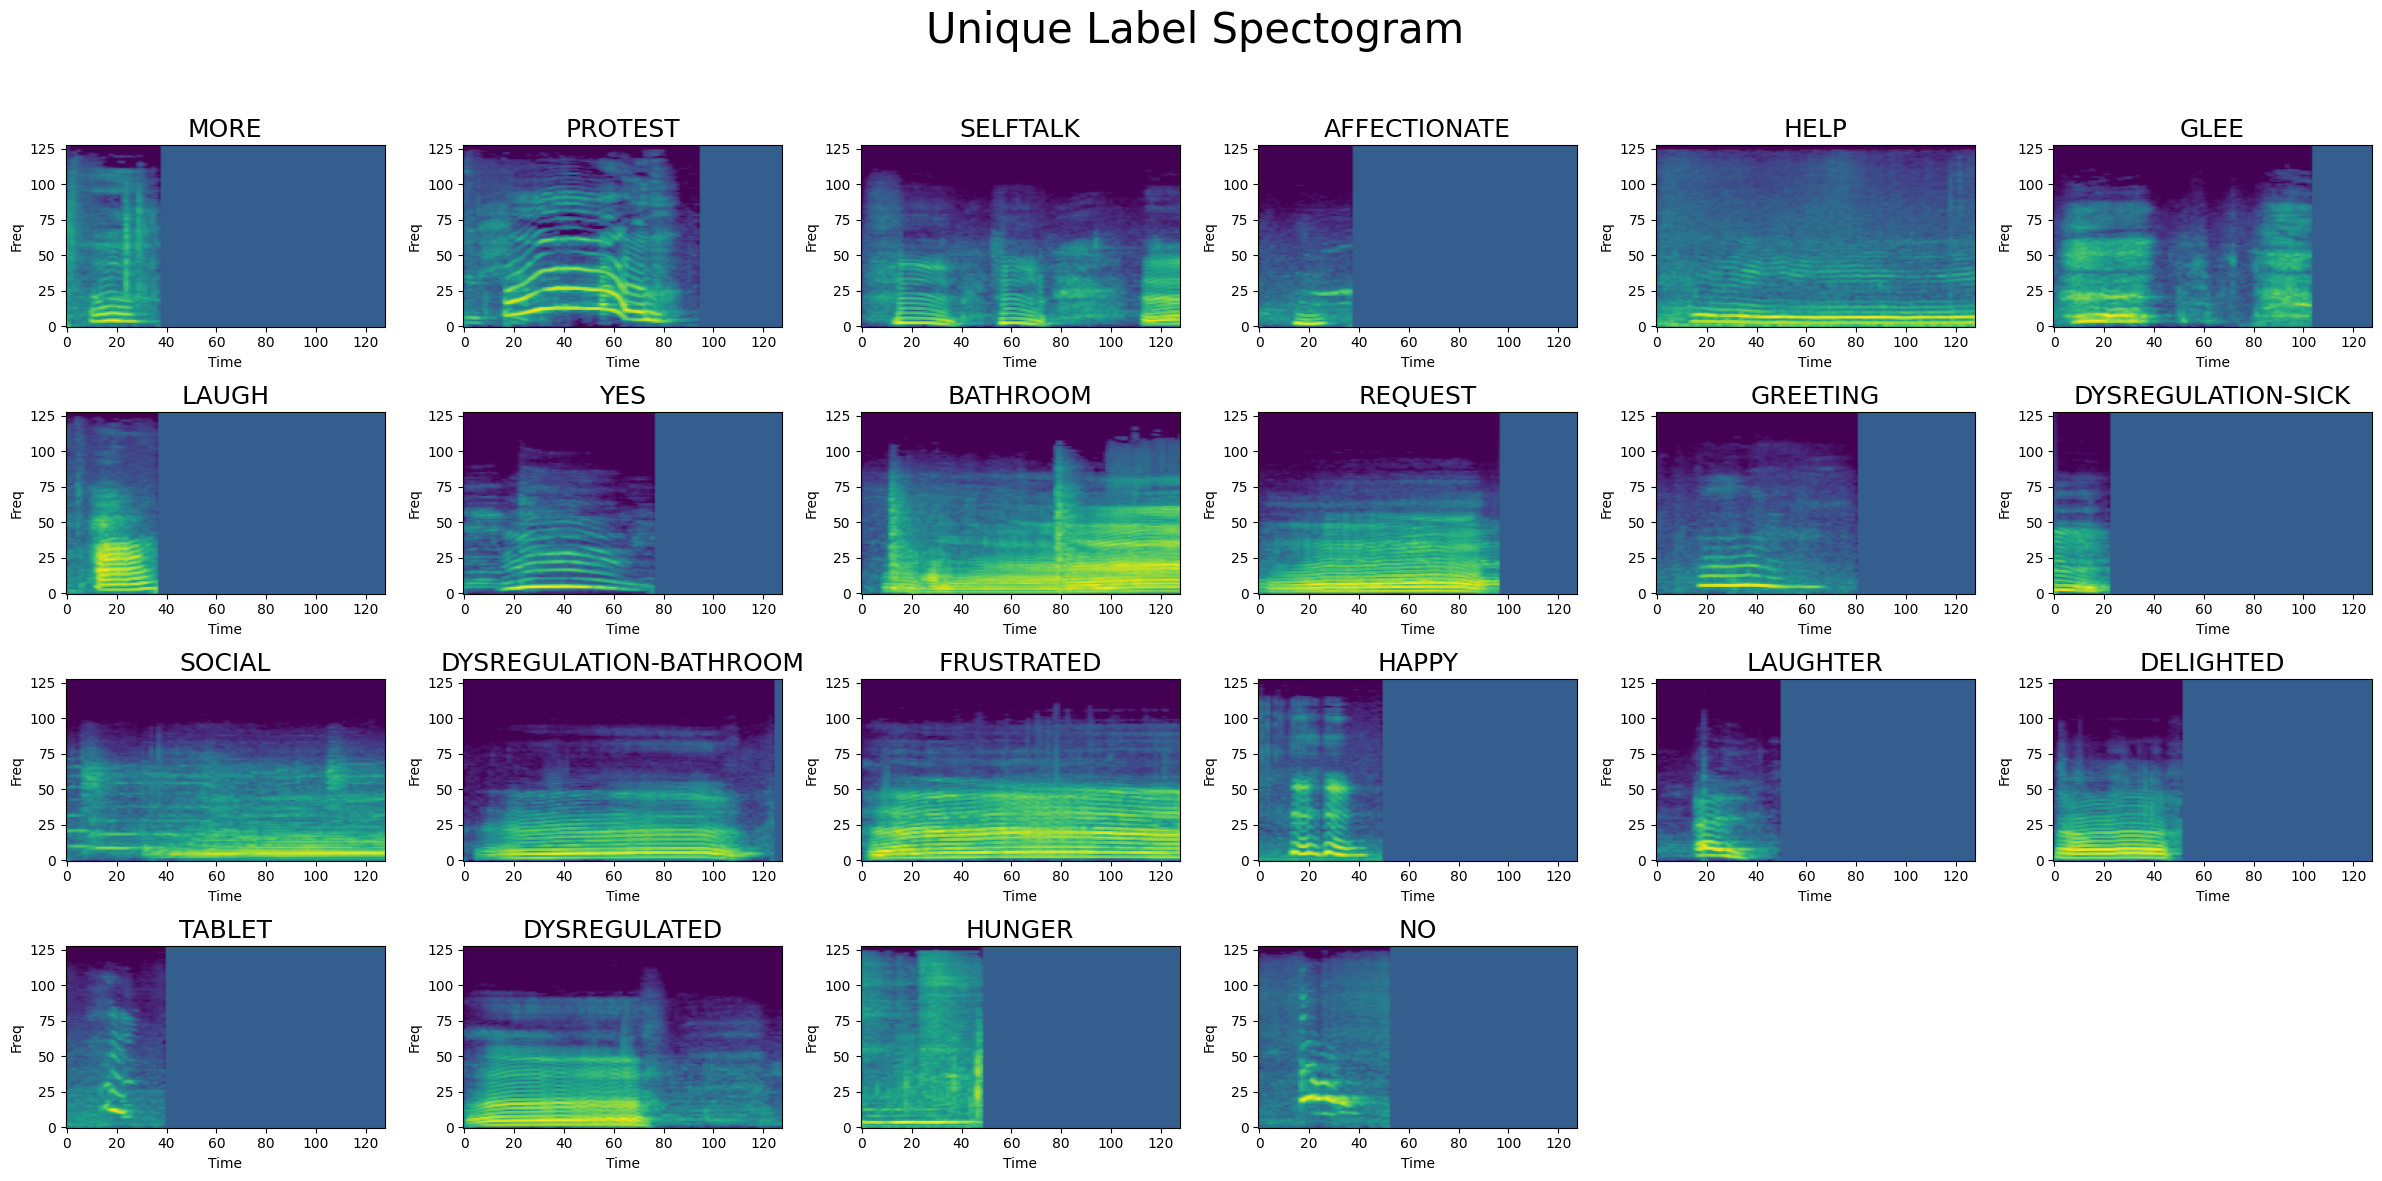

In [58]:
plot_unique_label_spectrograms_grid(df)

## Feature Extraction and Hypothesis Testing

### Tests Ran:
1. Pitch Variability Mann-Whitney 
2. MFCC Difference Mann-Whitney
3. ??

### Results: 
TODO

### Test 1: Pitch Variability between "Yes" and "No" with Mann-Whitney

In [ ]:
def batch_pitch_extraction(audio_list: List,
                           max_samples_per_batch: int=50,
                           sr: int=16000) -> List[float]:
    """
    Efficiently extract pitch features for a batch of audio samples
    
    Args:
        audio_list (list): List of audio arrays
        max_samples_per_batch (int): Maximum number of samples to process
        sr (int): Sampling rate
    
    Returns:
        list: Pitch standard deviation for each audio sample
    """
    # Randomly sample if batch is too large
    if len(audio_list) > max_samples_per_batch:
        sample_indices = np.random.choice(len(audio_list), max_samples_per_batch, replace=False)
        audio_list = [audio_list[i] for i in sample_indices]
    
    pitch_stds = []
    for audio_array in audio_list:
        try:
            audio_array = np.asarray(audio_array, dtype=np.float64)
            
            # Extract pitch using PYIN
            f0, voiced_flag, _ = librosa.pyin(
                audio_array, 
                fmin=librosa.note_to_hz('C2'),
                fmax=librosa.note_to_hz('C7'),
                sr=sr
            )
            
            # Filter for voiced segments
            f0_voiced = f0[voiced_flag]
            
            # Calculate pitch std, handle empty case
            pitch_std = float(np.std(f0_voiced)) if len(f0_voiced) > 0 else 0.0
            pitch_stds.append(pitch_std)
        
        except Exception as e:
            print(f"Pitch extraction error: {e}")
            pitch_stds.append(0.0)
    
    return pitch_stds

def pitch_variability_test(df: pl.DataFrame,
                           max_batch_size: int=50,
                           target_labels: List[str]=['frustrated', 'delighted']) -> Dict[str, float]:
    """
    Perform efficient pitch variability hypothesis test
    
    Args:
        df (pl.DataFrame): Input DataFrame
        target_labels (list): Labels to compare
    
    Returns:
        dict: Statistical test results
    """
    # Group audio by label
    label_audio_groups = {}
    for label in target_labels:
        # Extract audio for each label
        label_audio_groups[label] = df.filter(pl.col("Label") == label)["Audio"].to_list()
    
    # Batch pitch extraction
    label_pitch_stds = {}
    for label, audio_list in label_audio_groups.items():
        label_pitch_stds[label] = batch_pitch_extraction(audio_list=audio_list, max_samples_per_batch=max_batch_size)
        
        # Print basic stats
        pitch_array = np.array(label_pitch_stds[label])
        print(f"{label} samples: {len(pitch_array)}")
        print(f"  Mean pitch std: {np.mean(pitch_array):.4f}")
        print(f"  Std of pitch std: {np.std(pitch_array):.4f}")
    
    # Perform statistical tests
    label1_data = label_pitch_stds[target_labels[0]]
    label2_data = label_pitch_stds[target_labels[1]]
    
    # Mann-Whitney U Test
    u_statistic, p_value = scipy.stats.mannwhitneyu(
        label1_data, 
        label2_data, 
        alternative='two-sided'
    )
    
    # Effect size calculation (Cohen's d)
    mean1, std1 = np.mean(label1_data), np.std(label1_data)
    mean2, std2 = np.mean(label2_data), np.std(label2_data)
    
    # Pooled standard deviation
    pooled_std = np.sqrt(((len(label1_data) - 1) * std1**2 + 
                          (len(label2_data) - 1) * std2**2) / 
                         (len(label1_data) + len(label2_data) - 2))
    
    # Cohen's d
    cohens_d = (mean1 - mean2) / pooled_std
    
    # Prepare results
    results = {
        'Mann-Whitney U Statistic': u_statistic,
        'p-value': p_value,
        'Cohen\'s d': cohens_d,
        'Mean Difference': mean1 - mean2,
        'Significant': p_value < 0.05
    }
    
    # Print results
    print("\n=== Hypothesis Test Results ===")
    for key, value in results.items():
        print(f"{key}: {value}")
    
    return results

In [70]:
# Spectogram plotting functions to compare labels 
def plot_spectrogram_comparison(df, label1="yes", label2="no", sr=16000, n_examples=2):
    fig, axes = plt.subplots(n_examples, 2, figsize=(12, 4 * n_examples))
    label_map = {0: label1, 1: label2}

    for i, label in enumerate([label1, label2]):
        examples = df.filter(pl.col("Label") == label).head(n_examples).iter_rows(named=True)
        for j, row in enumerate(examples):
            y = np.array(row["Audio"])
            S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
            S_db = librosa.power_to_db(S, ref=np.max)
            ax = axes[j, i] if n_examples > 1 else axes[i]
            librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='mel', ax=ax)
            ax.set_title(f"{label_map[i].upper()} Sample #{j+1}")
            ax.set_xlabel("")
            ax.set_ylabel("")

    plt.suptitle("Mel Spectrogram Comparison: YES vs NO", fontsize=16)
    plt.tight_layout()
    plt.show()

In [73]:
t0 = time.time()
results = pitch_variability_test(df=df, max_batch_size=100, target_labels=["yes", "no"])
print(f"\n🎶 Pitch Variability Test completed in {time.time() - t0:.2f} seconds")

yes samples: 100
  Mean pitch std: 22.4608
  Std of pitch std: 21.7810
no samples: 12
  Mean pitch std: 119.1302
  Std of pitch std: 110.3414

=== Hypothesis Test Results ===
Mann-Whitney U Statistic: 247.0
p-value: 0.0009130241288154134
Cohen's d: -2.3838176989671234
Mean Difference: -96.66942680190178
Significant: True

🎶 Pitch Variability Test completed in 36.34 seconds


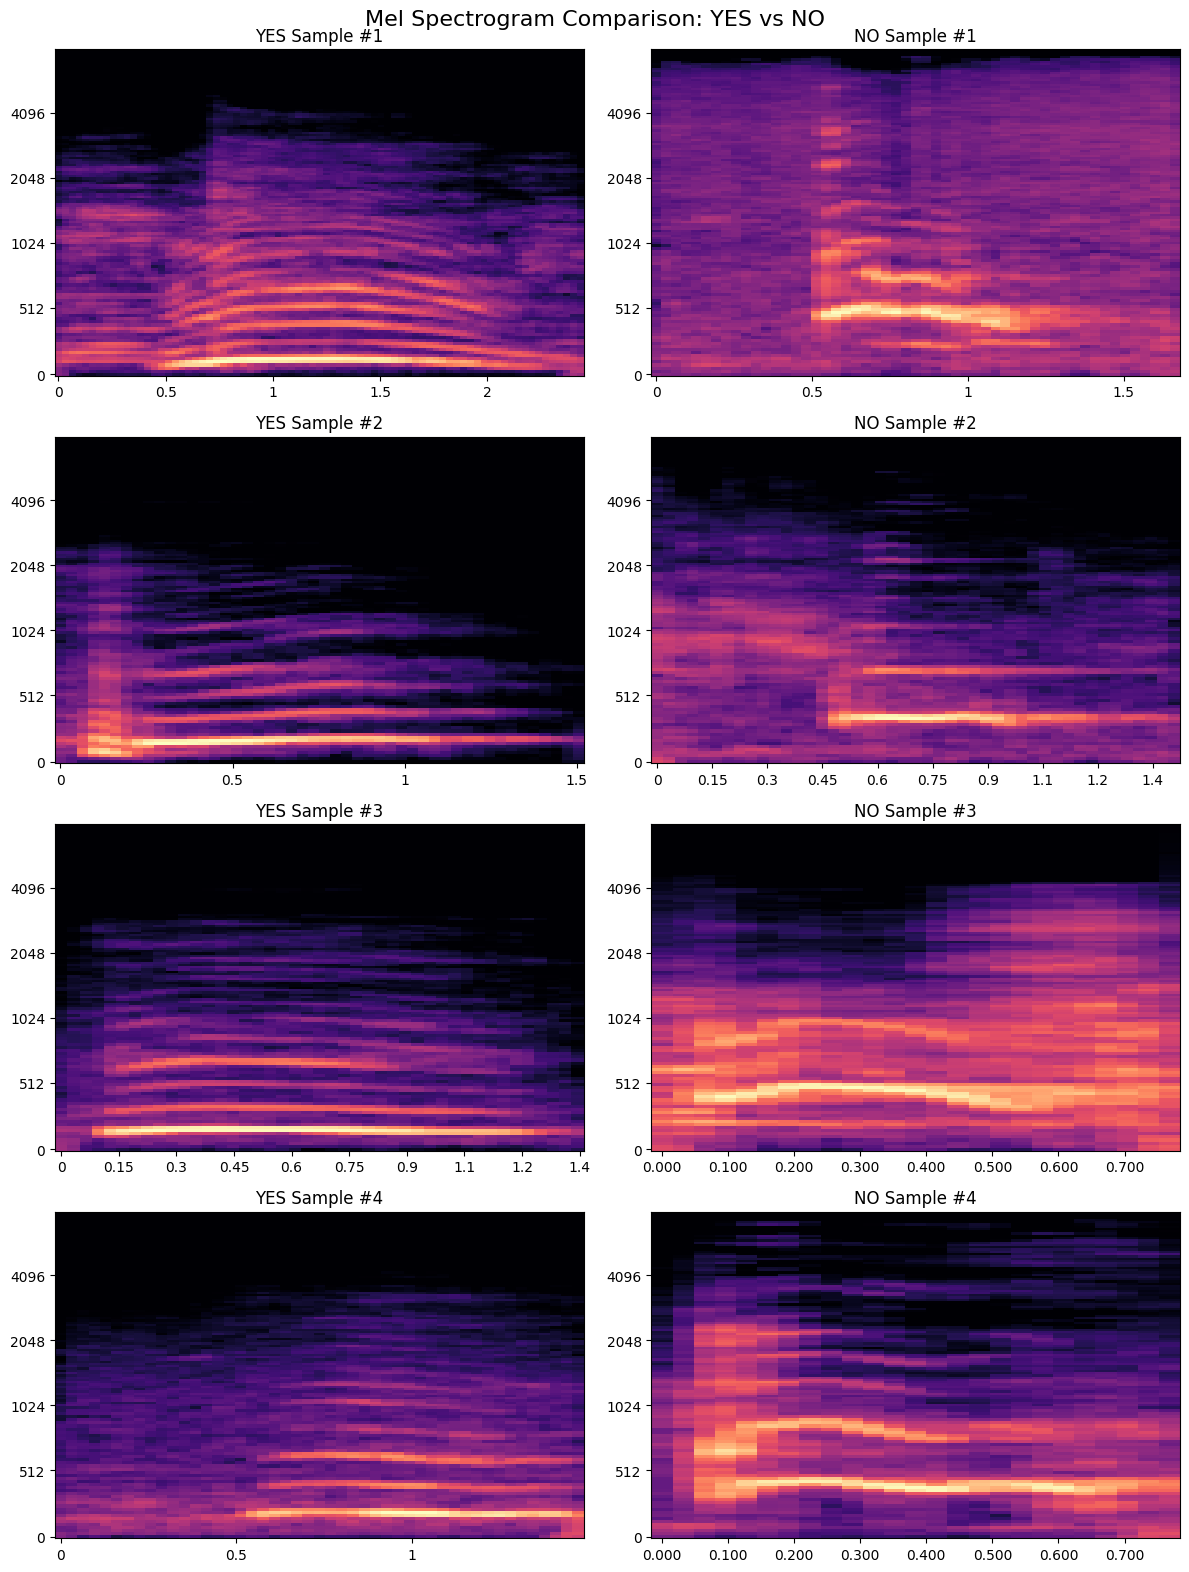

In [15]:
plot_spectrogram_comparison(df, label1="yes", label2="no", sr=16000, n_examples=4)

### Test 2: MFCC Mean Differences between "Yes" and "No" Vocalizations (Mann-Whitney U Test)

This test evaluates whether there are statistically significant differences in **spectral shape** between the vocalizations labeled as `"yes"` and `"no"`, using the **mean values of the first three MFCCs**.

---

#### What are MFCCs?

- **MFCC-1**: Captures the overall **spectral slope** — indicates the energy balance between low and high frequencies.
- **MFCC-2**: Captures the **curvature** of the spectral envelope — flat vs. peaked energy in the mid frequencies.
- **MFCC-3**: Represents **fine-grained variation** — subtle changes or "ripples" in the spectral shape.
- Higher-order MFCCs (4, 5, …) capture increasingly localized detail and high-frequency texture.

---

#### Test Setup

- **Statistic**: Mann-Whitney U test
- **Effect Size**: Cohen’s *d*
- **Input Features**: Mean of MFCC-1 to MFCC-3 per sample
- **Groups Compared**: `"yes"` vs `"no"` vocalizations
- **Sample Size**: 50 samples per label

---

#### Why This Matters

If MFCC means differ significantly between groups, it suggests that **spectral characteristics** of the vocalizations carry **discriminative information**. This can help differentiate types of vocal intent, even in non-verbal speech.

---

#### Results

__Group Means & Standard Deviations__

| Label | MFCC-1 Mean ± Std | MFCC-2 Mean ± Std | MFCC-3 Mean ± Std |
|-------|-------------------|-------------------|-------------------|
| **Yes** | -325.40 ± 35.08 | 125.82 ± 20.04 | 25.99 ± 16.56 |
| **No**  | -255.81 ± 48.42 | 128.74 ± 29.64 | -1.40 ± 20.49 |


__Statistical Results Summary__

| MFCC      | U Statistic | p-value        | Cohen’s *d* | Mean Diff | Significant |
|-----------|-------------|----------------|-------------|-----------|-------------|
| **MFCC-1** | 148.0       | 2.16e-05      | -1.90       | -69.59    | ✅ Yes       |
| **MFCC-2** | 571.0       | 0.7886        | -0.14       | -2.92     | ❌ No        |
| **MFCC-3** | 1010.0      | 0.00012      | +1.61       | +27.39    | ✅ Yes       |


### Interpretation:

- **MFCC-1** and **MFCC-3** show statistically significant and **large** differences between "yes" and "no" samples (Cohen’s *d* > 1.5).
- **MFCC-2** does not differ significantly between the two groups.
- These results indicate that **low and mid-frequency spectral properties** (slope and variation) carry meaningful differences between vocalizations, while overall mid-frequency curvature does not.

*This suggests that MFCC-1 and MFCC-3 may be useful features for classifying or clustering intent in non-verbal vocalizations.* 


In [ ]:
def batch_mfcc_extraction(audio_list: List,
                          max_samples_per_batch: int=50,
                          sr: int=16000,
                          n_coeffs: int=3) -> List[float]:
    """
    Efficiently extract MFCC features (mean of first n_coeffs) for a batch of audio samples.
    
    Returns:
        list: List of mean MFCC feature vectors for each sample.
    """
    if len(audio_list) > max_samples_per_batch:
        sample_indices = np.random.choice(len(audio_list), max_samples_per_batch, replace=False)
        audio_list = [audio_list[i] for i in sample_indices]
    
    mfcc_means = []
    for audio_array in audio_list:
        try:
            audio_array = np.asarray(audio_array, dtype=np.float32)
            mfccs = librosa.feature.mfcc(y=audio_array, sr=sr, n_mfcc=n_coeffs)
            mfcc_mean = np.mean(mfccs, axis=1)
            mfcc_means.append(mfcc_mean)
        except Exception as e:
            print(f"MFCC extraction error: {e}")
            mfcc_means.append(np.zeros(n_coeffs))
    
    return mfcc_means


def mfcc_significance_test(df, max_batch_size=50, target_labels=["frustrated", "delighted"], n_coeffs=3):
    """
    Efficiently extract MFCC features (mean of first n_coeffs) for a batch of audio samples.

    Args:
        audio_list (List): List of audio (numpy arrays or lists of float).
        max_samples_per_batch (int): Maximum number of audio samples to process from the input list.
                                     If the list is longer, a random subset will be used.
        sr (int): Sampling rate of the audio waveforms (in Hz).
        n_coeffs (int): Number of MFCC coefficients to compute and return per sample.
                        The function returns the mean of each coefficient across time.

    Returns:
        List[float]: A list of MFCC feature vectors (1D array of length n_coeffs per sample).
    """
    label_audio_groups = {}
    for label in target_labels:
        label_audio_groups[label] = df.filter(pl.col("Label") == label)["Audio"].to_list()
    
    label_mfcc_means = {}
    for label, audio_list in label_audio_groups.items():
        label_mfcc_means[label] = batch_mfcc_extraction(
            audio_list,
            max_samples_per_batch=max_batch_size,
            n_coeffs=n_coeffs
        )
        mfcc_array = np.array(label_mfcc_means[label])
        print(f"{label} samples: {len(mfcc_array)}")
        
        for i in range(n_coeffs):
            print(f"  MFCC-{i+1} Mean: {np.mean(mfcc_array[:, i]):.4f}, Std: {np.std(mfcc_array[:, i]):.4f}")

    results = {}
    for i in range(n_coeffs):
        data1 = [x[i] for x in label_mfcc_means[target_labels[0]]]
        data2 = [x[i] for x in label_mfcc_means[target_labels[1]]]

        u_statistic, p_value = scipy.stats.mannwhitneyu(data1, data2, alternative='two-sided')
        mean1, std1 = np.mean(data1), np.std(data1)
        mean2, std2 = np.mean(data2), np.std(data2)

        pooled_std = np.sqrt(((len(data1) - 1) * std1**2 + (len(data2) - 1) * std2**2) /
                             (len(data1) + len(data2) - 2))
        cohens_d = (mean1 - mean2) / pooled_std

        results[f"MFCC-{i+1}"] = {
            'U Statistic': u_statistic,
            'p-value': p_value,
            'Cohen\'s d': cohens_d,
            'Mean Difference': mean1 - mean2,
            'Significant': p_value < 0.05
        }

    print("\n=== MFCC Significance Test Results ===")
    for k, v in results.items():
        print(f"\n{k}")
        for stat, val in v.items():
            print(f"  {stat}: {val}")
    
    return results


In [ ]:
# Box whisker and heatmap to visualize distribution of MFCC (compare means)
def box_and_heat_mfcc_comparison(df, labels=["yes", "no"], sr=16000, n_mfcc=3):
    # Step 1: Prepare data
    data = []
    mfcc_data = {label: [] for label in labels}

    for label in labels:
        for row in df.filter(pl.col("Label") == label).iter_rows(named=True):
            y = np.array(row["Audio"])
            mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
            mfcc_mean = np.mean(mfccs, axis=1)

            # For boxplot
            for i in range(n_mfcc):
                data.append({
                    "MFCC": f"MFCC-{i+1}",
                    "Value": mfcc_mean[i],
                    "Label": label
                })

            # For heatmap
            mfcc_data[label].append(mfcc_mean)

    # DataFrames
    df_plot = pd.DataFrame(data)
    heat_data = []
    for label in labels:
        means = np.mean(np.stack(mfcc_data[label]), axis=0)
        row = [means[i] for i in range(n_mfcc)]
        heat_data.append(row)
    df_heat = pd.DataFrame(heat_data, columns=[f"MFCC-{i+1}" for i in range(n_mfcc)], index=[label.upper() for label in labels])

    # Step 2: Plot side-by-side
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # Boxplot
    sns.boxplot(data=df_plot, x="MFCC", y="Value", hue="Label", ax=axes[0])
    axes[0].set_title("MFCC Distribution (Boxplot)")
    axes[0].grid(True)

    # Heatmap
    sns.heatmap(df_heat, annot=True, fmt=".1f", cmap="viridis", ax=axes[1])
    axes[1].set_title("MFCC Mean Comparison (Heatmap)")
    axes[1].set_ylabel("Label")
    axes[1].set_xlabel("MFCC Coefficient")

    plt.tight_layout()
    plt.show()

In [91]:
t0 = time.time()
results = mfcc_significance_test(df, max_batch_size=100, target_labels=["yes", "no"], n_coeffs=3)
print(f"\n🎛️ MFCC Significance Test completed in {time.time() - t0:.2f} seconds")

yes samples: 100
  MFCC-1 Mean: -325.4005, Std: 35.0833
  MFCC-2 Mean: 125.8206, Std: 20.0408
  MFCC-3 Mean: 25.9935, Std: 16.5574
no samples: 12
  MFCC-1 Mean: -255.8073, Std: 48.4216
  MFCC-2 Mean: 128.7418, Std: 29.6434
  MFCC-3 Mean: -1.4004, Std: 20.4909

=== MFCC Significance Test Results ===

MFCC-1
  U Statistic: 148.0
  p-value: 2.1630933946929028e-05
  Cohen's d: -1.8995712995529175
  Mean Difference: -69.59324645996094
  Significant: True

MFCC-2
  U Statistic: 571.0
  p-value: 0.7886181528005375
  Cohen's d: -0.13780757784843445
  Mean Difference: -2.9212112426757812
  Significant: False

MFCC-3
  U Statistic: 1010.0
  p-value: 0.0001170365071430155
  Cohen's d: 1.6121885776519775
  Mean Difference: 27.39391326904297
  Significant: True

🎛️ MFCC Significance Test completed in 1.31 seconds


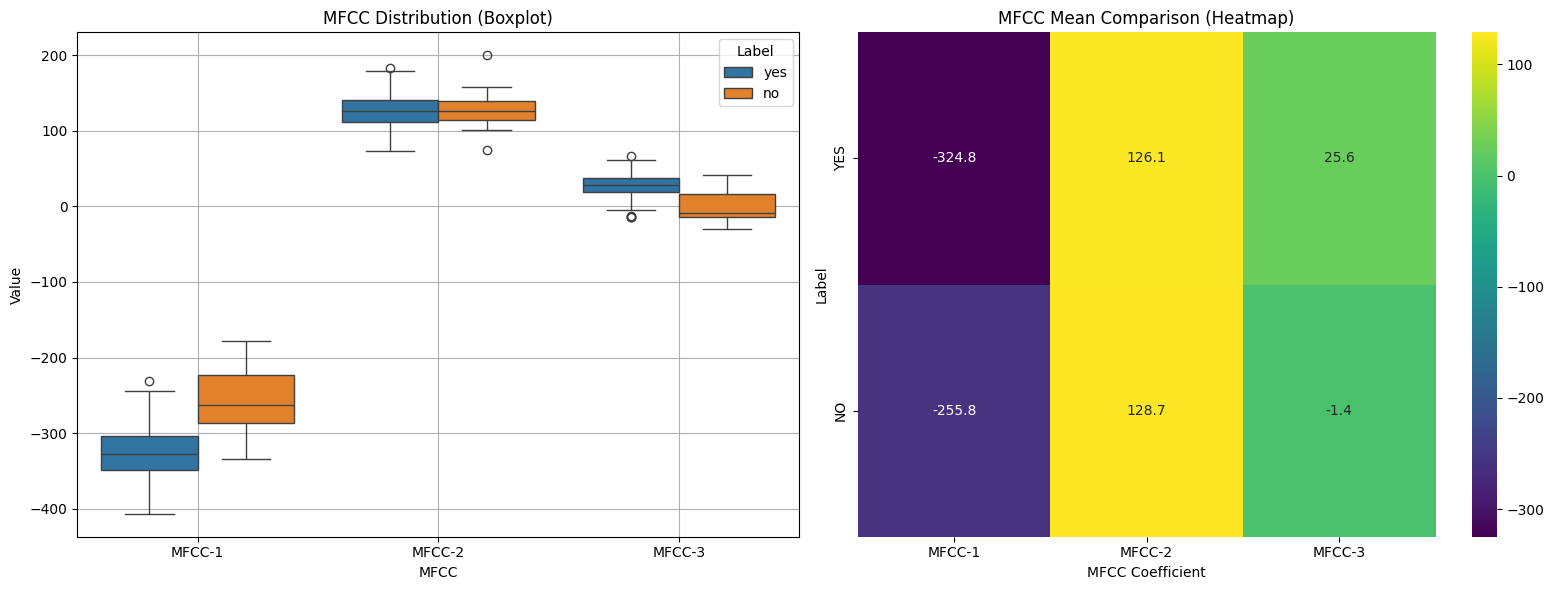

In [95]:
box_and_heat_mfcc_comparison(df, labels=["yes", "no"], n_mfcc=3)